In [83]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
import random

In [84]:
# local directory of images
file_dir = '../XN_Files/'

In each category, there are four images of the same brain. Each one of them has a different view/resolution that we can use to determine the class of hemhorrage.

../XN_Files/epidural/brain_bone_window/ID_0a3f30540.jpg


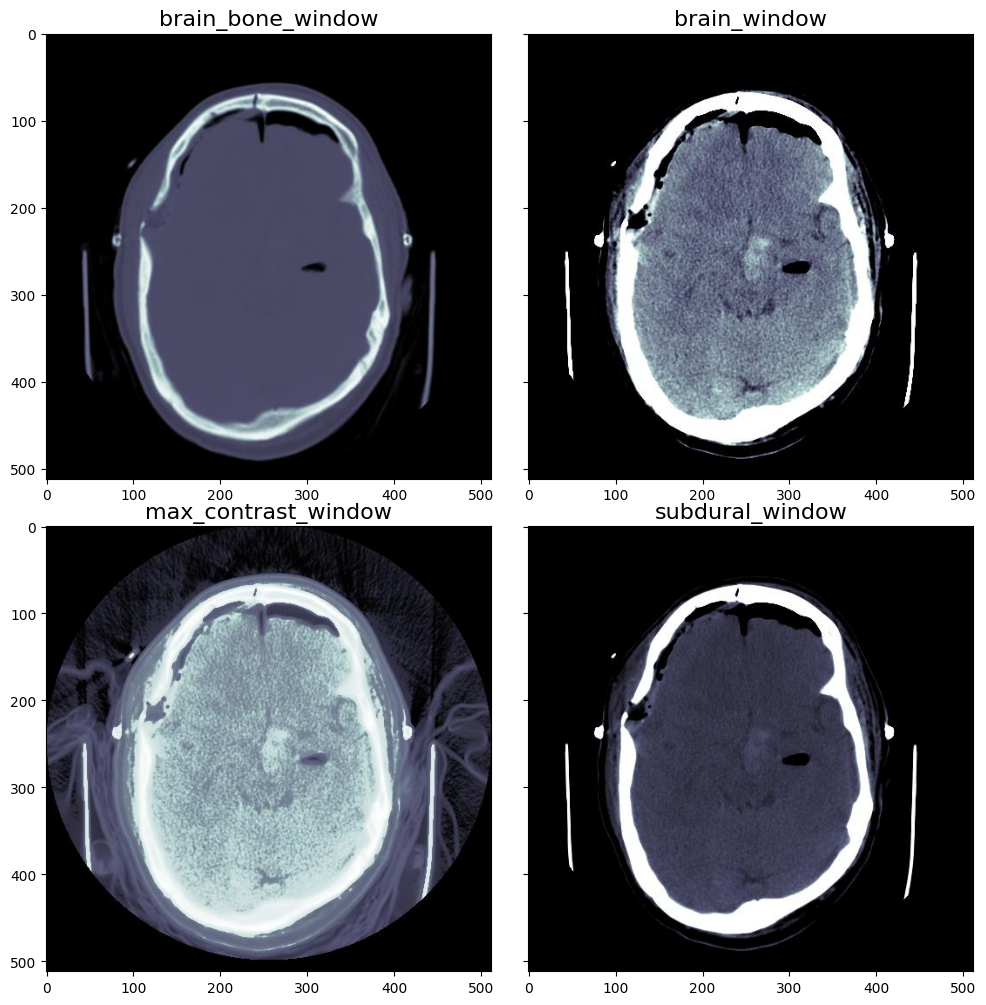

In [85]:
epidural = 'epidural/'
brain_bone = 'brain_bone_window'
brain_w = 'brain_window'
max_con = 'max_contrast_window'
subdural = 'subdural_window'

image_types = [(brain_bone, 0), (brain_w, 1), (max_con, 2), (subdural, 3)]

images = [mpimg.imread(file_dir + epidural + brain_bone + '/ID_0a3f30540.jpg'),
          mpimg.imread(file_dir + epidural +  brain_w + '/ID_0a3f30540.jpg'),
          mpimg.imread(file_dir + epidural +  max_con + '/ID_0a3f30540.jpg'),
         mpimg.imread(file_dir + epidural +  subdural + '/ID_0a3f30540.jpg')]

print(file_dir + epidural + brain_bone + '/ID_0a3f30540.jpg')

f, axes = plt.subplots(2, 2, sharey = True)
f.set_size_inches(10,10)
f.tight_layout()

axes = axes.reshape(4)

for i, j in zip(images, image_types):
    axes[j[1]].imshow(i)
    axes[j[1]].set_title(j[0], fontsize=16)


### Loading and Cleaning the Segmentation Files

In [86]:
#### Rename files for easiser processing -> ex. epidural.csv ###

In [87]:
# local directory of images
file_dir = '../XN_Files/'


#image types
brain_bone = 'brain_bone_window'
brain_w = 'brain_window'
max_con = 'max_contrast_window'
subdural = 'subdural_window'


#image size
im_size = 512*512

In [88]:
def convert_coordinates(coords):
    result = []
    for coord in eval(coords):
        result.append((np.array([[pair['x'], pair['y']] for pair in coord]) * 512).astype(int))
    return result

In [89]:
def load_labels(f_dir: str, image_type: str) -> pd.DataFrame:
    """Function to get hemmorhage labels. Method prerequisite: rename result csv files to match type_labels dict -> ex. epidural.csv, multi.csv"""
    # set class designations and relevant columns
    type_labels = {'epidural': 1, 'intraparenchymal': 2, 'subarachnoid': 3, 'subdural': 4, 'multi': 5,}
    column_names = ["Origin","Labeling State","All Labels","Majority Label", "Correct Label"]
    labels = pd.DataFrame()
    
    # for each hemorrhage type, load label data
    for k,v in type_labels.items():
        temp_data = pd.read_csv(file_dir + './Hemorrhage Segmentation Project/' + k + '.csv', low_memory=False)
        temp_data = temp_data[column_names]
        temp_data['Hemorrhage Type'] = k
        temp_data['Class'] = v
        labels = pd.concat([labels, temp_data])
        
    # drop all rows that are not labeled
    labeled = labels[labels['Labeling State']=='Labeled']
    gold = labels[labels['Labeling State']=='Gold Standard']
    labeled_df = pd.concat([labeled, gold]).dropna().reset_index().drop(['index'],axis = 1)
    

    
    # filter labeled images - only take images which hold correct labels
    labeled_df['Correct_Present'] = labeled_df['Correct Label'].apply(lambda x: 1 if "x" in x else 0)    
    labeled_df = labeled_df[labeled_df.Correct_Present==1].reset_index().drop(['index','Correct_Present'],axis = 1)
    
    
    # drop duplicates
    labeled_df = labeled_df.drop_duplicates(subset=['Origin']).reset_index().drop(['index'],axis = 1)
    
    # drop images with il-formatted coordinates
    labeled_df = labeled_df[labeled_df.Origin!='ID_6168d766c.jpg']
    labeled_df = labeled_df[labeled_df.Origin!='ID_1e643d438.jpg']
    labeled_df = labeled_df[labeled_df.Origin!='ID_233344b54.jpg']
    labeled_df = labeled_df[labeled_df.Origin!='ID_a39f8e984.jpg']
    labeled_df = labeled_df[labeled_df.Origin!='ID_acef57288.jpg']
    
    
    # convert coordinates for opencv use
    labeled_df["X-Y_segment"] = labeled_df['Correct Label'].apply(convert_coordinates)

    
    # add normal sample
    normal_sample_size = 500
    normal_images = os.listdir(file_dir + 'normal/' + image_type + '/')
    random.seed(123)
    normal_sample = random.sample(normal_images, k=normal_sample_size)
    norm_df = pd.DataFrame(normal_sample, columns=['Origin'])
    norm_df = norm_df.assign(**{ x : 'NA' for x in column_names[1:] })
    norm_df['Hemorrhage Type'] = 'normal'
    norm_df['Class'] = 6
    
    # final df
    final_labels = pd.concat([labeled_df, norm_df]).reset_index().drop(['index','All Labels','Majority Label'],axis = 1)
    final_labels['Image Type'] = image_type
    
    
    
    return final_labels

In [90]:
def load_data_per_image_type(file_dir: str, labels: pd.DataFrame, im_size: int) -> np.array([]):
    data = np.zeros([labels.shape[0], im_size])
    y = np.zeros([labels.shape[0],]).astype(int)
    print(f'Data Shape: {data.shape}', f'Label Shape: {y.shape}')
    for index, row in labels.iterrows():
        try:
            data[index,:] = np.mean(mpimg.imread(file_dir + row['Hemorrhage Type'] +'/'+ row['Image Type'] + '/' + row['Origin']), axis=2).reshape(-1)
            y[index] = row['Class']
        except Exception as e:
            print(f"Image {row['Origin']} is an incompatible size, skipping")
            continue   
    return data, y

#### Load data for max contrast window


In [91]:
# max_contrast_window
labels = load_labels(file_dir, max_con)
X, y = load_data_per_image_type(file_dir, labels, im_size)
labels

Data Shape: (1835, 262144) Label Shape: (1835,)
Image ID_88b0d8b4f.jpg is an incompatible size, skipping


,Origin,Labeling State,Correct Label,Hemorrhage Type,Class,X-Y_segment,Image Type
0,ID_004c4b319.jpg,Labeled,"[[{'x': 0.537109375, 'y': 0.89453125}, {'x': 0...",epidural,1,"[[[275, 458], [275, 457], [274, 457], [271, 45...",max_contrast_window
1,ID_02e2d273d.jpg,Labeled,"[[{'x': 0.46484375, 'y': 0.357421875}, {'x': 0...",epidural,1,"[[[238, 183], [238, 182], [237, 182], [229, 18...",max_contrast_window
2,ID_03c6a01ca.jpg,Labeled,"[[{'x': 0.55078125, 'y': 0.7265625}, {'x': 0.5...",epidural,1,"[[[282, 372], [282, 371], [281, 371], [280, 37...",max_contrast_window
3,ID_045196c9f.jpg,Labeled,"[[{'x': 0.591796875, 'y': 0.791015625}, {'x': ...",epidural,1,"[[[303, 405], [303, 401], [304, 401], [304, 39...",max_contrast_window
4,ID_0513bfa29.jpg,Labeled,"[[{'x': 0.78125, 'y': 0.6875}, {'x': 0.78125, ...",epidural,1,"[[[400, 352], [400, 344], [399, 344], [399, 34...",max_contrast_window
...,...,...,...,...,...,...,...
1830,ID_008bbcbc7.jpg,NA,NA,normal,6,NaN,max_contrast_window
1831,ID_002e03abf.jpg,NA,NA,normal,6,NaN,max_contrast_window
1832,ID_029747d7b.jpg,NA,NA,normal,6,NaN,max_contrast_window
1833,ID_0184b24fa.jpg,NA,NA,normal,6,NaN,max_contrast_window


In [92]:
# In case we want to examine the data manually
# labels.to_excel("data.xlsx", index = False)

**Analysis Setup**

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [94]:
# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print(f'Train Data Shape -> X: {X_train.shape}, y: {y_train.shape}')
print(f'Test Data Shape -> X: {X_test.shape}, y: {y_test.shape}')

Train Data Shape -> X: (1559, 262144), y: (1559,)
Test Data Shape -> X: (276, 262144), y: (276,)


**Logistic Regression**

In [ ]:
# tune our hyperparamters
param_grid = { 'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'max_iter': [1, 10, 50, 100] }

lr = LogisticRegression(solver='lbfgs')

grid_search = GridSearchCV(lr, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f'Best Hyperparameters: {grid_search.best_params_}')


In [95]:
og_clf = LogisticRegression(solver='lbfgs', max_iter=100)
og_clf.fit(X_train, y_train)
print("Logistic Regression Score: %.3f"%og_clf.score(X_test, y_test))

Logistic Regression Score: 0.315


/Users/n0342839/Desktop/Project/grad_school/ML/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [96]:
y_pred = og_clf.predict(X_test)

In [97]:
f1_score(y_test, y_pred, average='micro')

0.31521739130434784

In [98]:
optimized_clf = LogisticRegression(solver='lbfgs', max_iter=1, C=0.001)
optimized_clf.fit(X_train, y_train)
print("Logistic Regression Score: %.3f"%optimized_clf.score(X_test, y_test))

Logistic Regression Score: 0.319


/Users/n0342839/Desktop/Project/grad_school/ML/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [99]:
y_pred = optimized_clf.predict(X_test)

In [100]:
f1_score(y_test, y_pred, average='micro')

0.3188405797101449

**Confusion matrix - Original**

In [101]:
pred = og_clf.predict(X_test.reshape(-1, 262144))
print(pred[:5])

[6 2 3 4 4]


In [102]:
from sklearn.metrics import confusion_matrix

pred = og_clf.predict(X_test.reshape(-1, 262144))

conf_mx = confusion_matrix(y_test, pred)
conf_mx

array([[11,  5,  4,  3,  2,  9],
       [ 6, 28,  7,  9, 10, 18],
       [ 0, 13,  5,  2,  4,  6],
       [ 3,  9,  4,  7,  6,  6],
       [ 3,  4,  0,  2,  3, 10],
       [ 7,  7,  7, 16,  7, 33]])

<AxesSubplot: >

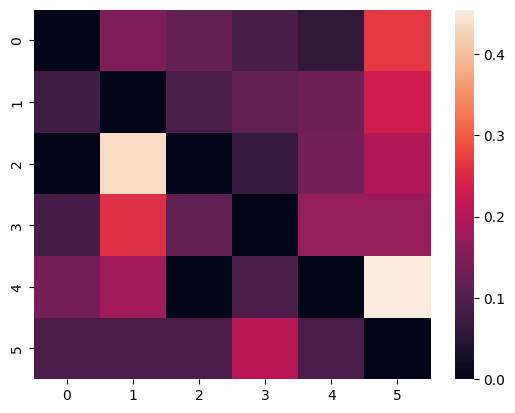

In [103]:
import seaborn as sns

row_sum = conf_mx.sum(axis=1, keepdims=True)
nconf_mx = conf_mx/row_sum
np.fill_diagonal(nconf_mx,0)

sns.heatmap(nconf_mx)

***Confusion matrix - 'Opitimized'***

In [104]:
pred = optimized_clf.predict(X_test.reshape(-1, 262144))
print(pred[:5])

[6 2 2 2 6]


In [105]:
from sklearn.metrics import confusion_matrix

pred = optimized_clf.predict(X_test.reshape(-1, 262144))

conf_mx = confusion_matrix(y_test, pred)
conf_mx

array([[ 0,  5,  0,  0,  0, 29],
       [ 0, 17,  0,  0,  0, 61],
       [ 0,  7,  0,  0,  0, 23],
       [ 0,  7,  0,  0,  0, 28],
       [ 0,  5,  0,  0,  0, 17],
       [ 0,  6,  0,  0,  0, 71]])

<AxesSubplot: >

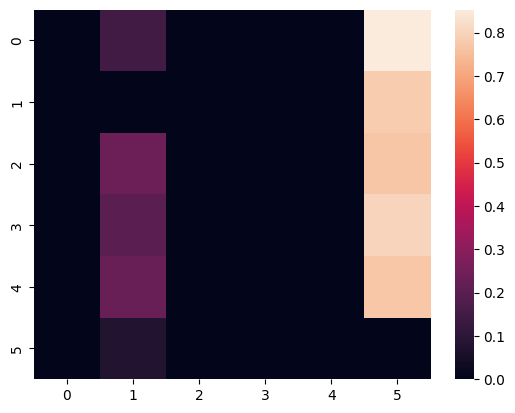

In [106]:
import seaborn as sns

row_sum = conf_mx.sum(axis=1, keepdims=True)
nconf_mx = conf_mx/row_sum
np.fill_diagonal(nconf_mx,0)

sns.heatmap(nconf_mx)

**LDA**

In [107]:
lda = LinearDiscriminantAnalysis(store_covariance=False)
lda.fit(X_train, y_train)
print("LDA Score: %.3f"%lda.score(X_test, y_test))

LDA Score: 0.337


In [108]:
y_pred = lda.predict(X_test)

In [109]:
f1_score(y_test, y_pred, average='micro')

0.33695652173913043

**Random Forest**

In [ ]:
# Instantiate random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit model on training data
rf.fit(X_train, y_train)

# Make predictions on testing data
y_pred = rf.predict(X_test)

# Evaluate model accuracy
accuracy = rf.score(X_test, y_test)
print(f"Model accuracy: {accuracy}")

In [ ]:
# tune our hyperparameters

# Instantiate random forest classifier
rf = RandomForestClassifier(random_state=0)

# Define hyperparameters for grid search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3]
}

In [ ]:
# Instantiate grid search with 2-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=2)

# Fit grid search on training data
grid_search.fit(X_train, y_train)

# Get best hyperparameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print results
print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")

In [ ]:
# from sklearn.model_selection import cross_val_score, StratifiedKFold

# # Instantiate random forest classifier
# rf = RandomForestClassifier(random_state=0)

# # Define number of folds for stratified k-fold cross-validation
# n_splits = 2

# # Instantiate stratified k-fold cross-validation object
# skf = StratifiedKFold(n_splits=n_splits)

# # Compute cross-validation scores
# cv_scores = cross_val_score(rf, X, y, cv=skf)

# # Print results
# print(f"Cross-validation scores: {cv_scores}")
# print(f"Mean score: {cv_scores.mean()}")

In [110]:
# run with best params

# Instantiate random forest classifier
rf = RandomForestClassifier(n_estimators=150, random_state=0, max_depth=15, min_samples_leaf=2, min_samples_split=5)

# Fit model on training data
rf.fit(X_train, y_train)

# Make predictions on testing data
y_pred = rf.predict(X_test)

# Evaluate model accuracy
accuracy = rf.score(X_test, y_test)
print(f"Model accuracy: {accuracy}")

Model accuracy: 0.38768115942028986


In [111]:
f1_score(y_test, y_pred, average='micro')

0.38768115942028986

**XGBoost**

In [ ]:
# set up XGBoost classifier
clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=42, learning_rate=0.3)

# train the classifier on the training data
clf.fit(X_train, y_train)

# make predictions on the test data
y_pred = clf.predict(X_test)

# evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

Gives an accuracy of 41.88%

In [ ]:
# tune our hyperparameters

# Instantiate random forest classifier
clf = xgb.XGBClassifier(objective='binary:logistic', nthread=4, seed=42)

# Define hyperparameters for grid search
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [ ]:
# Instantiate grid search with 2-fold cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=2)

# Fit grid search on training data
grid_search.fit(X_train, y_train)

# Get best hyperparameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print results
print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")

In [ ]:
# run with best params

# set up XGBoost classifier
clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=42)

# train the classifier on the training data
clf.fit(X_train, y_train)

# make predictions on the test data
y_pred = clf.predict(X_test)

# evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

## Segmentation


In [15]:
from collections import Counter
import ast
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import pickle

import os
os.environ['QT_BACKEND'] = 'osx'
import cv2

In [16]:
labels = load_labels(file_dir, max_con)
X, y = load_data_per_image_type(file_dir, labels, im_size)
labels.to_csv("segment.csv", index = False)

Data Shape: (1842, 262144) Label Shape: (1842,)
Image ID_88b0d8b4f.jpg is an incompatible size, skipping


In [17]:
segment = pd.read_csv('segment.csv')
labels = segment[segment['Hemorrhage Type'] != 'normal']

In [16]:
labels


,Origin,Labeling State,Correct Label,Hemorrhage Type,Class,X-Y_segment,Image Type
0,ID_004c4b319.jpg,Labeled,"[[{'x': 0.537109375, 'y': 0.89453125}, {'x': 0...",epidural,1,"[array([[275, 458],\n [275, 457],\n ...",max_contrast_window
1,ID_02e2d273d.jpg,Labeled,"[[{'x': 0.46484375, 'y': 0.357421875}, {'x': 0...",epidural,1,"[array([[238, 183],\n [238, 182],\n ...",max_contrast_window
2,ID_03c6a01ca.jpg,Labeled,"[[{'x': 0.55078125, 'y': 0.7265625}, {'x': 0.5...",epidural,1,"[array([[282, 372],\n [282, 371],\n ...",max_contrast_window
3,ID_045196c9f.jpg,Labeled,"[[{'x': 0.591796875, 'y': 0.791015625}, {'x': ...",epidural,1,"[array([[303, 405],\n [303, 401],\n ...",max_contrast_window
4,ID_0513bfa29.jpg,Labeled,"[[{'x': 0.78125, 'y': 0.6875}, {'x': 0.78125, ...",epidural,1,"[array([[400, 352],\n [400, 344],\n ...",max_contrast_window
...,...,...,...,...,...,...,...
1837,ID_008bbcbc7.jpg,NaN,NaN,normal,6,NaN,max_contrast_window
1838,ID_002e03abf.jpg,NaN,NaN,normal,6,NaN,max_contrast_window
1839,ID_029747d7b.jpg,NaN,NaN,normal,6,NaN,max_contrast_window
1840,ID_0184b24fa.jpg,NaN,NaN,normal,6,NaN,max_contrast_window


In [20]:
def create_mask(index):
    """ method that takes index and returns mask as a nested lists of coordinates """ 
    
    img_id = labels.iloc[index]['Origin']
    st = labels.iloc[index]['Correct Label']
    coords = ast.literal_eval(st)
    
    # empty mask to fill in
    
    img = np.zeros((512, 512), dtype=np.uint8)

    masks = []
    for coord in coords:
        
        # data quality issues, some of the lists have length == 0,
        # skip these as they don't provide anything new
        
        if len(coord) == 0:
            continue
        
        # extract coordinates and multiply by 512
        
        xy = [list(v.values()) for v in coord]
        xy = [[element * 512 for element in inner_list] for inner_list in xy]
        
        # fill in the shape created by the given vertices
        mask = np.zeros_like(img)
        cv2.fillPoly(mask, np.int32([xy]), 255)
        masks.append(mask)
        
    # take the sum of all masks to generate one image
    
    final_mask = sum(masks)
    
    return final_mask

**create mask images**

In [37]:
photo_type = max_con

# create directories for images

if not os.path.exists('u_net_data'):
    os.mkdir('u_net_data')

if not os.path.exists('u_net_data/masks'):
    os.mkdir('u_net_data/masks')

if not os.path.exists('u_net_data/images'):
    os.mkdir('u_net_data/images')

if not os.path.exists('u_net_data/mask_pickle'):
    os.mkdir('u_net_data/mask_pickle')

# iterate through every index of the labeled file

for index in range(labels.shape[0]):
    
    img_id = labels.iloc[index]['Origin']
    st = labels.iloc[index]['Correct Label']
    image_type = labels.iloc[index]['Hemorrhage Type'] + '/'

    # empty mask for normal hemorrhage
    
    if image_type == "normal/":
        mask = np.zeros((512, 512), dtype=np.uint8)
    else:
        mask = create_mask(index)
        
    # save the mask image to mask folder
    
    mask_dir = 'u_net_data/masks'
    mask_path = os.path.join(mask_dir, img_id)
    plt.imsave(mask_path, mask)
    
    # save mask pickle
    
    with open(f'u_net_data/mask_pickle/{img_id.split(".")[0]}.pickle', 'wb') as file:
        pickle.dump(mask, file)
    
    # save the original image to image folder
    
    img_orig = mpimg.imread(file_dir + image_type + photo_type + '/' + img_id)
    save_dir = 'u_net_data/images'
    save_path = os.path.join(save_dir, img_id)
    plt.imsave(save_path, img_orig)

### Exploratory Mask Analysis

1
../XN_Files/epidural/max_contrast_window/ID_5c0509ab8.jpg


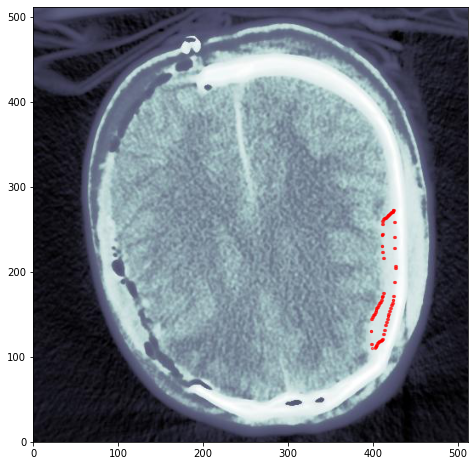

In [38]:
i = 81

photo_type = max_con
st = labels.iloc[i]['Correct Label']
coords = ast.literal_eval(st)

xys = []
for coord in coords:
    xy = [list(v.values()) for v in coord]
    xy = [[element * 512 for element in inner_list] for inner_list in xy]
    xys.append(xy)
    
print(len(xys))

img_id = labels.iloc[i]['Origin']
image_type = labels.iloc[i]['Hemorrhage Type'] + '/'

file_dir

print(file_dir + image_type + photo_type + '/' + img_id)

f, ax = plt.subplots()
f.set_size_inches(8,8)

ax.imshow(mpimg.imread(file_dir + image_type + photo_type + '/' + img_id))

# image will be flipped becasue matplotlib and cv2 have different origins (top left, bottom left)

for xy in xys:
    df = pd.DataFrame(xy)
    ax.scatter(df[0], df[1], s=5, alpha=0.5, c = 'red')
    ax.set_xlim(0, 512)
    ax.set_ylim(0, 512)

plt.show()


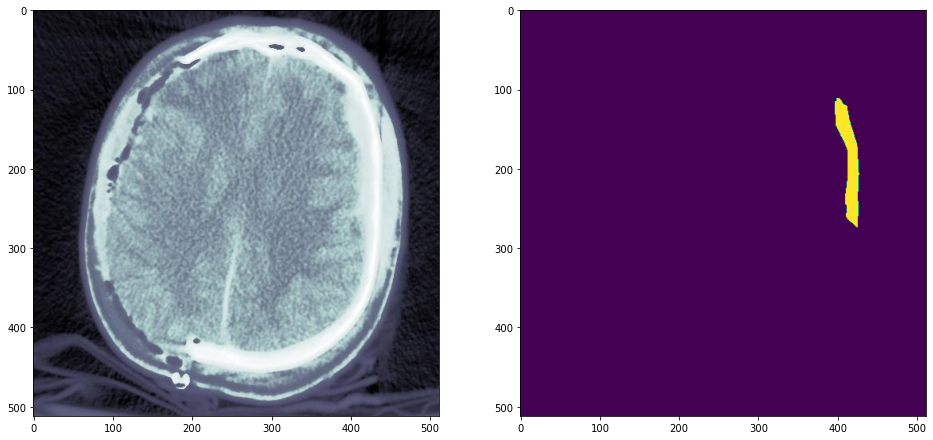

In [39]:
img = np.zeros((512, 512), dtype=np.uint8)

masks = []
for shape in xys:
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, np.int32([shape]), 255)
    masks.append(mask)

s = sum(masks)

img_orig = mpimg.imread(file_dir + image_type + photo_type + '/' + img_id)

f, ax = plt.subplots(1, 2)
f.set_size_inches(16, 8)

ax[0].imshow(img_orig)
ax[1].imshow(s)

plt.show()

**Data Aggregation**

In [59]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from skimage.io import imread
import pickle

In [20]:
seg_df = labels.filter(['Origin','Class'], axis=1)
seg_df['Mask'] = seg_df.Origin
seg_df

,Origin,Class,Mask
0,ID_004c4b319.jpg,1,ID_004c4b319.jpg
1,ID_02e2d273d.jpg,1,ID_02e2d273d.jpg
2,ID_03c6a01ca.jpg,1,ID_03c6a01ca.jpg
3,ID_045196c9f.jpg,1,ID_045196c9f.jpg
4,ID_0513bfa29.jpg,1,ID_0513bfa29.jpg
...,...,...,...
1330,ID_f2922aa82.jpg,2,ID_f2922aa82.jpg
1331,ID_5e12a82a0.jpg,3,ID_5e12a82a0.jpg
1332,ID_ac8229f7a.jpg,3,ID_ac8229f7a.jpg
1333,ID_361518736.jpg,5,ID_361518736.jpg


In [21]:
data_dir = 'u_net_data'
image_dir = os.path.join(data_dir, 'images')
mask_dir = os.path.join(data_dir, 'masks')
pickle_dir = os.path.join(data_dir, 'mask_pickle')

In [22]:
img_height, img_width = 512, 512

In [23]:
first_n = 300
image_list = os.listdir(image_dir)
if '.ipynb_checkpoints' in image_list:
    image_list.remove('.ipynb_checkpoints')
    image_list = image_list#[:first_n]
mask_list = os.listdir(mask_dir)#[:first_n]
pickle_list = os.listdir(pickle_dir)#[:first_n]
print(f'number of samples {len(image_list)}')
print(f'number of samples {len(pickle_list)}')

number of samples 1335
number of samples 1335


In [25]:
X = np.zeros((len(image_list), img_height, img_width, 3), dtype=np.float32)
y = np.zeros((len(mask_list), img_height, img_width, 1), dtype=np.int8)
remove = []
for i, (image, mask) in tqdm(enumerate(zip(image_list, mask_list))):
    try:
        img = imread(os.path.join(image_dir, image))
        X[i] = img / 255
        pickle_name = os.path.join(pickle_dir, mask.split('.')[0] + '.pickle')
        with open(pickle_name, "rb") as file:
            mask = pickle.load(file)
        y[i] = mask.reshape(img_height, img_width, 1)
        if len(np.unique(mask)) != 2: # data quality
            remove.append(i)
    except:
        remove.append(i)
        continue
X = np.delete(X, remove, axis=0)
y = np.delete(y, remove, axis=0)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

1335it [00:25, 51.99it/s]


In [26]:
# manually remove item 673.. script is ignoring it for some reason
X = np.delete(X, [673], axis=0)
y = np.delete(y, [673], axis=0)

In [27]:
# Create a TensorFlow dataset with TensorSpecs
image_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
image_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(512, 512, 1), dtype=tf.int8, name=None))>

In [28]:
def resize(image, mask):
    resized_image = tf.image.resize(image, [128, 128]) / 255
    resized_mask = tf.image.resize(mask, [128, 128])
    cast_mask = tf.cast(resized_mask, dtype=tf.int32)
    cast_mask += 1

    return resized_image, cast_mask

In [29]:
image_dataset = image_dataset.map(resize)

In [30]:
image_dataset

<MapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.int32, name=None))>

In [224]:
# save for later - come back and refactor how the dataset is created
# def load_and_preprocess_segmentation(image_name, mask_name):
#     # read resize and normalize image
#     image_path = 'u_net_data/images/' + image_name
#     image = tf.io.read_file(image_path)
#     image_decoded = tf.image.decode_jpeg(image, channels=3)
#     resized_image = tf.image.resize(image_decoded, [128, 128]) / 255
#     # read resize and normalize mask
#     mask_path = 'u_net_data/masks/' + mask_name
#     mask = tf.io.read_file(mask_path)
#     mask_decoded = tf.image.decode_jpeg(mask, channels=1)
#     resized_mask = tf.image.resize(mask_decoded, [128, 128])
#     image = tf.cast(resized_mask, dtype=tf.int32)
#     image = image * 255
    
#     return resized_image, resized_mask

In [225]:
# image_dataset = image_dataset.map(load_and_preprocess_segmentation).prefetch(-1)

In [31]:
# split into train and test
test_size = int(len(image_dataset) * 0.2)

image_dataset = image_dataset.shuffle(buffer_size=len(seg_df))

train_dataset = image_dataset.skip(test_size)
test_dataset = image_dataset.take(test_size)

print("Number of elements in train dataset:", len(list(train_dataset)))
print("Number of elements in test dataset:", len(list(test_dataset)))

Number of elements in train dataset: 1057
Number of elements in test dataset: 264


In [317]:
# perform a single augmentation by randomly flipping an image
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
#         # both use the same seed, so they'll make the same random changes.
#         self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
#         self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, images, masks):
        inputs = self.augment_inputs(images)
        labels = self.augment_labels(masks)
        return inputs, masks

In [32]:
TRAIN_LENGTH = len(list(train_dataset))
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [33]:
train_batches = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
#     .map(Augment())
#     .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_dataset.batch(BATCH_SIZE)
train_batches

<RepeatDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>

In [36]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
        plt.show()

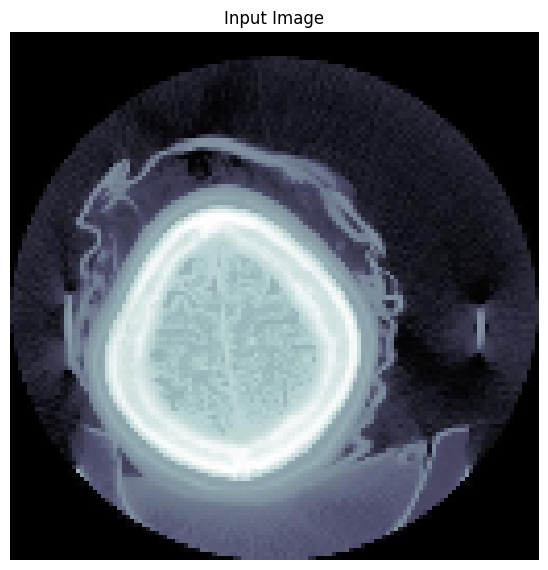

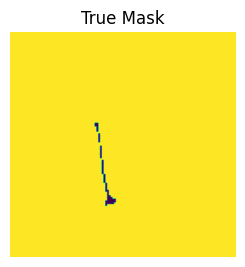

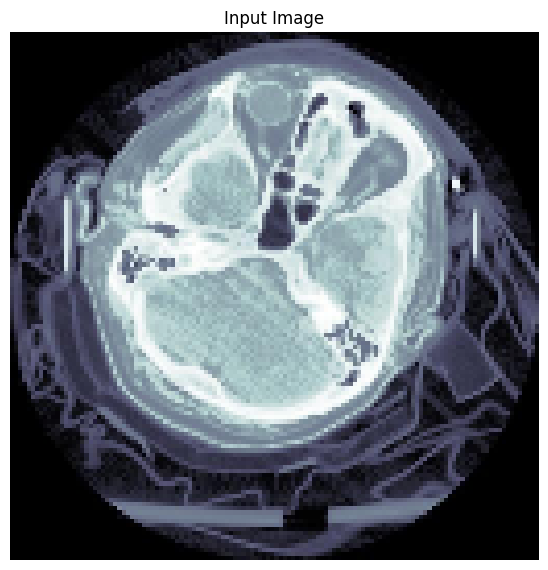

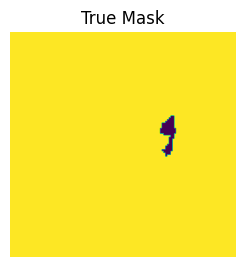

In [37]:
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

*** Custom Metric and Loss Functions***

In [78]:
def dice_coefficient(y_true, y_pred):
    print("y_true shape:", y_true.shape)
    print("y_pred shape:", y_pred.shape)
    smooth = 1.
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [73]:
def dice_loss(y_true, y_pred):
    print("y_true shape:", y_true.shape)
    print("y_pred shape:", y_pred.shape)
    
    loss = 1 - dice_coefficient(y_true, y_pred)
    return loss

In [62]:
# def bce_dice_loss(y_true, y_pred):
#     loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
#     return loss

***Define the model***

In [41]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [42]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [43]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [81]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

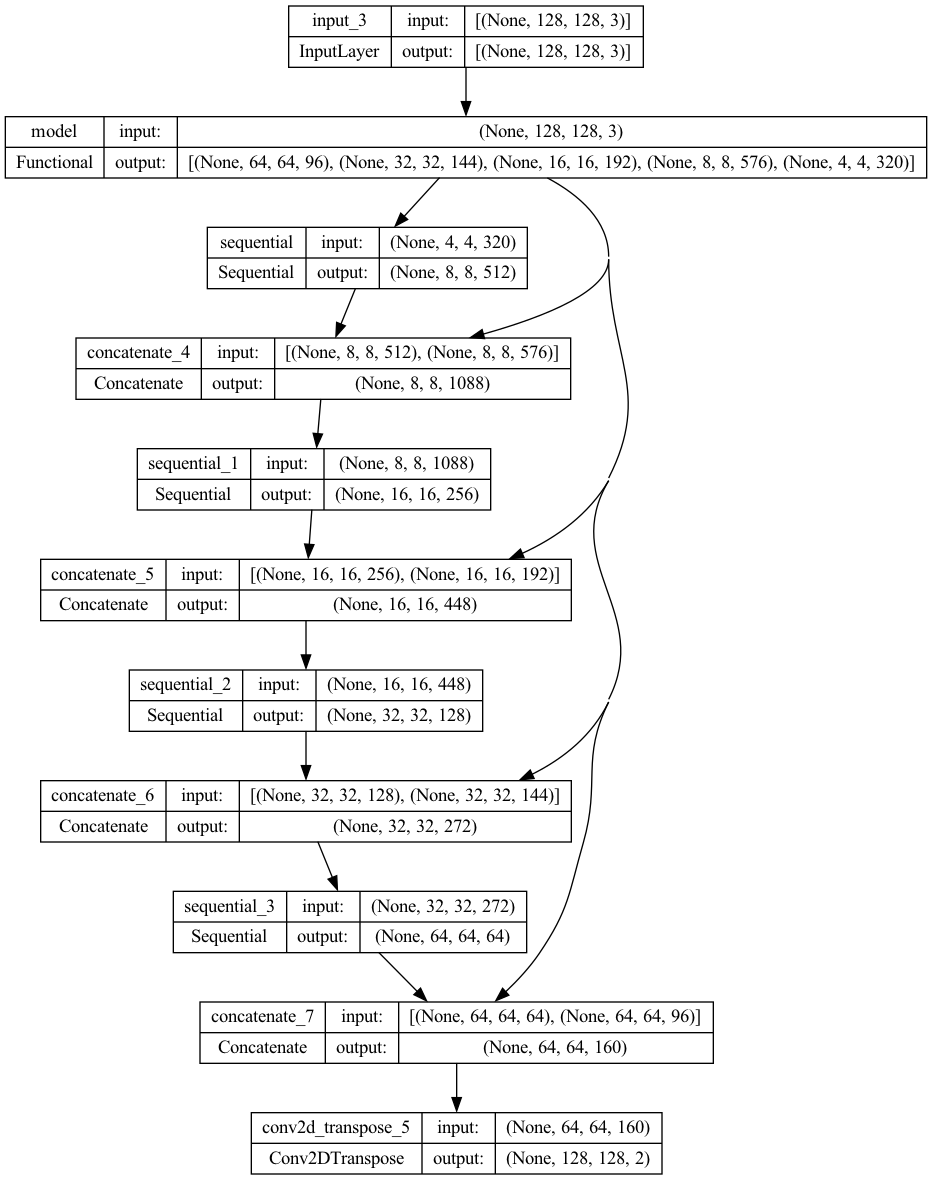

In [68]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [46]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [47]:
def show_predictions(dataset=None, num=1):
    if dataset:
        try:
            for image, mask in dataset.take(num):
                pred_mask = model.predict(image)
                display([image[0], mask[0], create_mask(pred_mask)])
        except Error as e:
            print(e)
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 750ms/step


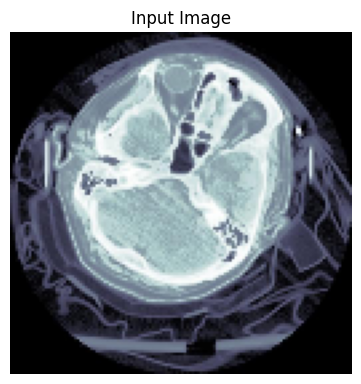

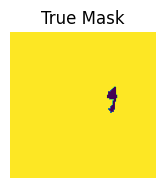

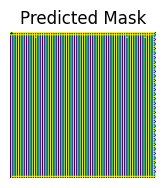

In [48]:
show_predictions()

In [49]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 77ms/step


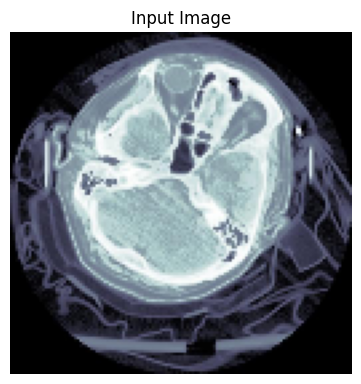

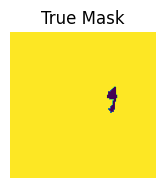

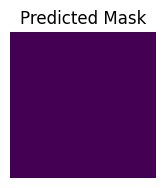


Sample Prediction after epoch 20

33/33 [==============================] - 25s 761ms/step - loss: 0.0429 - accuracy: 0.9910 - val_loss: 0.0312 - val_accuracy: 0.9940


In [82]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS =  len(list(test_dataset))//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

In [79]:
# we can see the probabilities of each pixel value being 'hemorrhage' or 'no hemorrhage'

pred_mask = model.predict(sample_image[tf.newaxis, ...])
tf.reshape(pred_mask, [-1])

1/1 [==============================] - 0s 34ms/step


<tf.Tensor: shape=(32768,), dtype=float32, numpy=
array([ 0.89301944, -1.2503221 , -0.75712395, ...,  1.1214416 ,
        0.19966912,  1.0126559 ], dtype=float32)>

In [80]:
tf.reshape(sample_mask, [-1])

<tf.Tensor: shape=(16384,), dtype=int32, numpy=array([1, 1, 1, ..., 1, 1, 1], dtype=int32)>

## CNN


Create image folder to pull from

In [116]:
photo_type = max_con

# create directories for images

if not os.path.exists('cnn_images'):
    os.mkdir('cnn_images')
    
for index in range(labels.shape[0]):
    
    img_id = labels.iloc[index]['Origin']
    st = labels.iloc[index]['Correct Label']
    image_type = labels.iloc[index]['Hemorrhage Type'] + '/'
    
    # save the original image to image folder
    
    img_orig = mpimg.imread(file_dir + image_type + photo_type + '/' + img_id)
    save_dir = 'cnn_images'
    save_path = os.path.join(save_dir, img_id)
    plt.imsave(save_path, img_orig)


In [117]:
import tensorflow as tf

In [134]:
labels = load_labels(file_dir, max_con)
X, y = load_data_per_image_type(file_dir, labels, im_size)
labels.to_csv("segment.csv", index = False)

Data Shape: (1835, 262144) Label Shape: (1835,)
Image ID_88b0d8b4f.jpg is an incompatible size, skipping


In [135]:
labels = pd.read_csv('segment.csv')

In [136]:
cnn_df = labels.filter(['Origin','Class'], axis=1)
cnn_df

,Origin,Class
0,ID_004c4b319.jpg,1
1,ID_02e2d273d.jpg,1
2,ID_03c6a01ca.jpg,1
3,ID_045196c9f.jpg,1
4,ID_0513bfa29.jpg,1
...,...,...
1830,ID_008bbcbc7.jpg,6
1831,ID_002e03abf.jpg,6
1832,ID_029747d7b.jpg,6
1833,ID_0184b24fa.jpg,6


In [143]:
image_dataset = tf.data.Dataset.from_tensor_slices((cnn_df.Origin, cnn_df.Class))
image_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [144]:
def load_and_preprocess(image_name, label):
    # read resize and normalize image
    image_path = 'cnn_images/' + image_name
    image = tf.io.read_file(image_path)
    image_decoded = tf.image.decode_jpeg(image, channels=3)
    resized_image = tf.image.resize(image_decoded, [256, 256]) / 255
    
    return resized_image, label

In [145]:
image_dataset = image_dataset.map(load_and_preprocess).prefetch(-1)

In [146]:
n = image_dataset.cardinality().numpy()
print(n)

1835


In [147]:
# split into train and test
#'train[:80%]', 'train[80%:90%]', 'train[90%:]']

train_split1 = int(n * 0.8)
train_split2 = int(n * 0.9)

#test_size = int(len(image_dataset) * 0.2)

image_dataset = image_dataset.shuffle(buffer_size=len(seg_df))

train_dataset = image_dataset.take(train_split1)
val_dataset = image_dataset.skip(train_split1).take(train_split2 - train_split1)
test_dataset = image_dataset.skip(train_split2)

print("Number of elements in train dataset:", len(list(train_dataset)))
print("Number of elements in validation dataset:", len(list(val_dataset)))
print("Number of elements in test dataset:", len(list(test_dataset)))

Number of elements in train dataset: 1468
Number of elements in validation dataset: 183
Number of elements in test dataset: 184


In [148]:
# perform a single augmentation by randomly flipping an image
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, images, labels):
        inputs = self.augment_inputs(images)
        return inputs, labels

In [149]:
TRAIN_LENGTH = len(list(train_dataset))
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [150]:
train_batches = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(BATCH_SIZE)

train_batches = train_dataset.batch(BATCH_SIZE).prefetch(1)
val_batches = val_dataset.batch(BATCH_SIZE).prefetch(1)
test_batches = test_dataset.batch(BATCH_SIZE).prefetch(1)

print(train_batches)
print(val_batches)
print(test_batches)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [163]:
num_classes = len(tf.unique(cnn_df.Class).y) + 1

print("Number of classes: ", num_classes)

Number of classes:  7


In [164]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Conv2D 
from tensorflow import keras

In [165]:
input_shape = (256, 256, 3)

# Define the model
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False, input_shape= input_shape)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(num_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

 block4_sepconv1_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 32, 32, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 32, 32, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 16, 16, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 16, 16, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_31 (Add)                   (None, 16, 16, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_30[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 16, 16, 728)  0          ['add_31[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 16, 16, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 16, 16, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 16, 16, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 16, 16, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_34 (A

In [166]:
for layer in base_model.layers:
    layer.trainable = False


In [167]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_batches, epochs=20, validation_data=val_batches)

Epoch 1/20
46/46 [==============================] - 72s 2s/step - loss: 1.6879 - accuracy: 0.3460 - val_loss: 1.3870 - val_accuracy: 0.4645
Epoch 2/20
46/46 [==============================] - 96s 2s/step - loss: 1.5603 - accuracy: 0.4005 - val_loss: 1.3744 - val_accuracy: 0.5137
Epoch 3/20
46/46 [==============================] - 92s 2s/step - loss: 1.4726 - accuracy: 0.4271 - val_loss: 1.4229 - val_accuracy: 0.4262
Epoch 4/20
46/46 [==============================] - 85s 2s/step - loss: 1.4118 - accuracy: 0.4598 - val_loss: 1.3899 - val_accuracy: 0.4645
Epoch 5/20
46/46 [==============================] - 94s 2s/step - loss: 1.4117 - accuracy: 0.4571 - val_loss: 1.2339 - val_accuracy: 0.5464
Epoch 6/20
46/46 [==============================] - 92s 2s/step - loss: 1.3828 - accuracy: 0.4884 - val_loss: 1.3728 - val_accuracy: 0.4863
Epoch 7/20
46/46 [==============================] - 92s 2s/step - loss: 1.3827 - accuracy: 0.4619 - val_loss: 1.2688 - val_accuracy: 0.5301
Epoch 8/20
46/46 [==

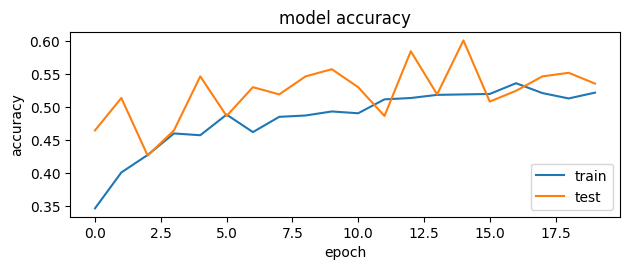

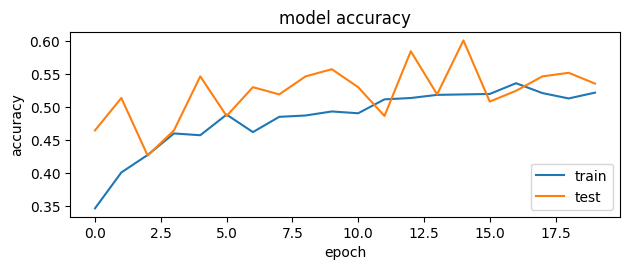

In [168]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.tight_layout()

fig